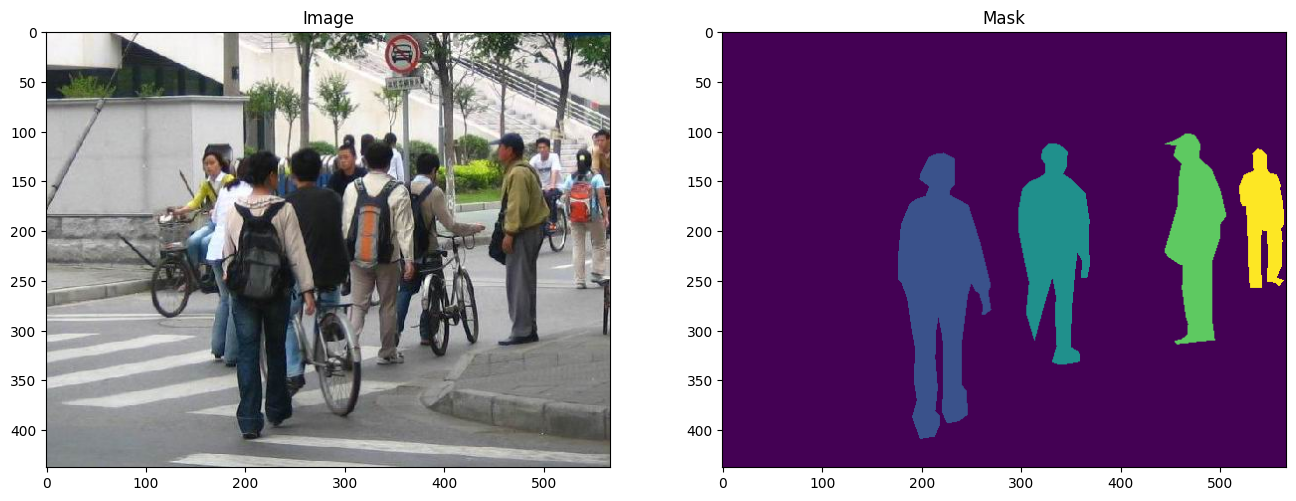

In [32]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image('data/PennFudanPed/PNGImages/FudanPed00046.png')
mask = read_image('data/PennFudanPed/PedMasks/FudanPed00046_mask.png')

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [33]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        """
        Initialize the PennFudanDataset.

        Args:
            root (str): Root directory containing images and masks.
            transforms (callable): A function/transform to apply to both images and target data.
        """
        self.root = root
        self.transforms = transforms
        # Load all image file names and sort them to ensure alignment between images and masks
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        """
        Retrieve an image and target (bounding boxes, masks, etc.) by index.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            img (torch.Tensor): The image tensor.
            target (dict): Dictionary containing bounding boxes, masks, labels, and metadata.
        """
        # Load image and mask file paths
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        # Read the image and mask into tensors
        img = read_image(img_path)
        mask = read_image(mask_path)

        # Retrieve unique object IDs encoded in the mask (e.g., instance labels)
        obj_ids = torch.unique(mask)
        # Remove the first ID, which corresponds to the background
        obj_ids = obj_ids[1:]

        # Determine the number of objects in the mask
        num_objs = len(obj_ids)

        # Split the color-encoded mask into binary masks for each object
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # Compute bounding box coordinates for each binary mask
        boxes = masks_to_boxes(masks)

        # Assign a single class label (1 for "person") to all objects
        labels = torch.ones((num_objs,), dtype=torch.int64)

        # Additional metadata for the target
        image_id = idx  # Unique ID for each image
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])  # Compute area of each bounding box
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)  # Indicate all instances are not crowd

        # Wrap image and target annotations into torchvision tv_tensors for consistency
        img = tv_tensors.Image(img)
        target = {
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img)),
            "masks": tv_tensors.Mask(masks),
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # Apply transformations (if any) to the image and target
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        # Return the processed image and its corresponding target
        return img, target

    def __len__(self):
        """
        Return the total number of items in the dataset.

        Returns:
            int: Number of items in the dataset.
        """
        return len(self.imgs)

In [34]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

# replace the classifier with a new one, that has
# num_classes which user-defined
num_classes = 2 # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [35]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# Load a pre-trained MobileNetV2 model for classification, and extract the feature layers to use as a backbone
backbone = torchvision.models.mobilenet_v2(weights='DEFAULT').features

# Set the number of output channels in the backbone.
# For MobileNetV2, it outputs 1280 channels in the last feature map layer.
backbone.out_channels = 1280

# Define the anchor generator used by the Region Proposal Network (RPN).
# This will define 5 different sizes [(32, 64, 128, 256, 512)] and 3 different aspect ratios [(0.5, 1.0, 2.0)]
# for the anchors generated across the feature map.
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),  # Anchor box sizes
    aspect_ratios=((0.5, 1.0, 2.0),)  # Anchor box aspect ratios
)

# Define the Region of Interest (RoI) pooling module.
# This module crops and scales feature maps to a standard size (7x7 in this case)
# for each region of interest (bounding box).
# featmap_names=['0'] specifies that we are using the feature map from the first (or only) level of the backbone.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],        # The feature map to use for RoIAlign
    output_size=7,             # The output size of each RoI feature map
    sampling_ratio=2           # Number of samples used to compute outputs for RoIAlign
)

# Combine the backbone, anchor generator, and RoI pooling components into a Faster-RCNN model.
# Faster-RCNN is a popular object detection architecture that combines a CNN backbone with
# a Region Proposal Network (RPN) to identify candidate object regions.
# num_classes=2 because we are detecting 1 class (e.g., "person") + background.
model = FasterRCNN(
    backbone,                           # The feature extractor network
    num_classes=2,                      # The number of object classes
    rpn_anchor_generator=anchor_generator,  # The anchor generator for the RPN
    box_roi_pool=roi_pooler            # The RoI pooling layer
)

In [36]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    """
    Creates an instance segmentation model based on Mask R-CNN, pre-trained on COCO dataset,
    and customizes it to work for the specified number of classes.

    Args:
        num_classes (int): Number of object classes in the dataset (e.g., 1 class + background).

    Returns:
        model (torchvision.models.detection.MaskRCNN): The customized instance segmentation model.
    """

    # Load a pre-trained Mask R-CNN model with ResNet-50 backbone and FPN (Feature Pyramid Network)
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # Get the number of input features for the bounding box classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained bounding box predictor with a new one for the specified number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256  # Set the number of hidden units for the mask predictor

    # Replace the pre-trained mask predictor with a new one for the specified number of classes
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,  # Input channels for the mask predictor
        hidden_layer,      # Number of hidden layers in the mask predictor
        num_classes        # Output channels for the mask predictor (number of classes)
    )

    # Return the customized model
    return model

In [37]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

--2025-02-24 23:46:46--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py.2’

     0K ...                                                   100% 89.1M=0s

2025-02-24 23:46:46 (89.1 MB/s) - ‘engine.py.2’ saved [4063/4063]

--2025-02-24 23:46:46--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.co

0

In [38]:
from torchvision.transforms import v2 as T


def get_transform(train):
    """
    Define a set of transformations to apply to the dataset during training or evaluation.

    Args:
        train (bool): If True, apply training-specific transformations such as random horizontal flipping.

    Returns:
        T.Compose: A composed list of transformations.
    """
    # Initialize an empty list to store transformations
    transforms = []

    # If training, add a random horizontal flip transformation with a 50% probability
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))

    # Add transformation to cast data to floating-point with optional scaling
    transforms.append(T.ToDtype(torch.float, scale=True))

    # Add transformation to convert data into a pure tensor format
    transforms.append(T.ToPureTensor())

    # Return the composed list of transformations
    return T.Compose(transforms)

In [39]:
import utils

# Load a pre-trained Faster R-CNN model with ResNet-50 backbone and FPN (Feature Pyramid Network)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Load the dataset for training with the specified data transformations
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))

# Create a DataLoader to handle the dataset during training
# Batch size of 2, shuffle the data, and use a custom collate function to combine samples.
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,               # Process 2 samples per batch during training
    shuffle=True,               # Randomly shuffle the data at the beginning of each epoch
    collate_fn=utils.collate_fn # Custom function to handle batching of data
)

# For Training
# Get a batch of images and targets from the data loader
images, targets = next(iter(data_loader))

# Convert images and targets into the correct format
images = list(image for image in images)  # Prepare the images as a list
targets = [{k: v for k, v in t.items()} for t in targets] # Prepare the targets as dictionaries

# Perform a forward pass through the model with the training data.
# This will return both losses and detections.
output = model(images, targets)
print(output)  # Output the losses (e.g., classification loss, box regression loss) and predictions.

# For Inference
model.eval()  # Set the model to evaluation mode to disable dropout and other training-specific behavior

# Define a list of random input tensors simulating images
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]

# Perform inference on the input data
# This will return predictions (e.g., bounding boxes, labels, scores)
predictions = model(x)
print(predictions[0])  # Output the predictions for the first input image

{'loss_classifier': tensor(0.1390, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0292, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0192, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0025, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [40]:
from engine import train_one_epoch, evaluate

# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define the number of classes in the dataset: 1 class (person) + background
num_classes = 2

# Load the training and testing datasets with transformations
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# Split the data into training and testing sets
indices = torch.randperm(len(dataset)).tolist()  # Shuffle data indices
dataset = torch.utils.data.Subset(dataset, indices[:-50])  # Use all but the last 50 images for training
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])  # Use the last 50 images for testing

# Create data loaders for training and testing
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,  # Load 2 images per batch
    shuffle=True,  # Shuffle data for each epoch
    collate_fn=utils.collate_fn  # Use the utility function to handle batches of variable image sizes
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,  # Load 1 image per batch for evaluation
    shuffle=False,  # Do not shuffle during testing
    collate_fn=utils.collate_fn  # Use the same collate function
)

# Initialize the Mask R-CNN model for instance segmentation
model = get_model_instance_segmentation(num_classes)

# Transfer the model to the selected device
model.to(device)

# Set up the optimizer to update model parameters during training
# Using Stochastic Gradient Descent (SGD) with a learning rate of 0.005, momentum, and weight decay
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# Set up a learning rate scheduler to decrease the learning rate after specific epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,  # Reduce the learning rate every 3 epochs
    gamma=0.1     # Multiply the learning rate by 0.1
)

# Specify the number of epochs to train the model
num_epochs = 2

# Training loop
for epoch in range(num_epochs):
    # Train the model for one epoch, log the progress every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # Step the learning rate scheduler to update the learning rate
    lr_scheduler.step()
    # Evaluate the model using the test dataset to measure performance
    evaluate(model, data_loader_test, device=device)

# Print a confirmation message after training is complete
print("That's it!")

Epoch: [0]  [ 0/60]  eta: 0:07:42  lr: 0.000090  loss: 6.2552 (6.2552)  loss_classifier: 0.6081 (0.6081)  loss_box_reg: 0.4347 (0.4347)  loss_mask: 5.1765 (5.1765)  loss_objectness: 0.0308 (0.0308)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 7.7162  data: 0.0279
Epoch: [0]  [10/60]  eta: 0:06:02  lr: 0.000936  loss: 1.9695 (3.0078)  loss_classifier: 0.4308 (0.3946)  loss_box_reg: 0.3646 (0.3145)  loss_mask: 1.0448 (2.2749)  loss_objectness: 0.0163 (0.0178)  loss_rpn_box_reg: 0.0050 (0.0061)  time: 7.2428  data: 0.0217
Epoch: [0]  [20/60]  eta: 0:04:39  lr: 0.001783  loss: 0.7803 (1.8733)  loss_classifier: 0.1688 (0.2708)  loss_box_reg: 0.2073 (0.2534)  loss_mask: 0.4676 (1.3259)  loss_objectness: 0.0123 (0.0169)  loss_rpn_box_reg: 0.0031 (0.0063)  time: 6.9407  data: 0.0187
Epoch: [0]  [30/60]  eta: 0:03:26  lr: 0.002629  loss: 0.5796 (1.4671)  loss_classifier: 0.1093 (0.2191)  loss_box_reg: 0.1848 (0.2385)  loss_mask: 0.2505 (0.9882)  loss_objectness: 0.0055 (0.0139)  loss_rpn_box_reg: 

{'boxes': tensor([[168.9919, 125.9223, 273.2995, 412.5073],
        [294.0610, 115.4241, 370.7981, 340.7467],
        [446.2168, 104.1035, 507.9731, 318.3598],
        [519.0527, 114.5724, 564.7953, 258.7419],
        [361.5166, 123.1345, 441.1275, 329.2251],
        [240.2293, 126.4524, 316.6898, 384.7860],
        [260.1568, 123.6386, 513.6075, 331.7270],
        [488.6226, 106.4505, 518.9536, 202.5023],
        [242.9848, 113.0908, 305.1574, 284.0461],
        [284.4630, 110.0724, 317.7961, 172.7499],
        [340.5046,  98.4145, 359.5657, 153.3245],
        [542.7677, 108.8927, 565.5106, 254.1075],
        [166.7043, 119.5915, 386.9194, 422.6542],
        [392.0537,  95.7744, 525.2243, 327.3727]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'scores': tensor([0.9933, 0.9923, 0.9829, 0.9802, 0.9547, 0.4474, 0.2624, 0.2200, 0.1599,
        0.1159, 0.1082, 0.0706, 0.0578, 0.0546]), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0.

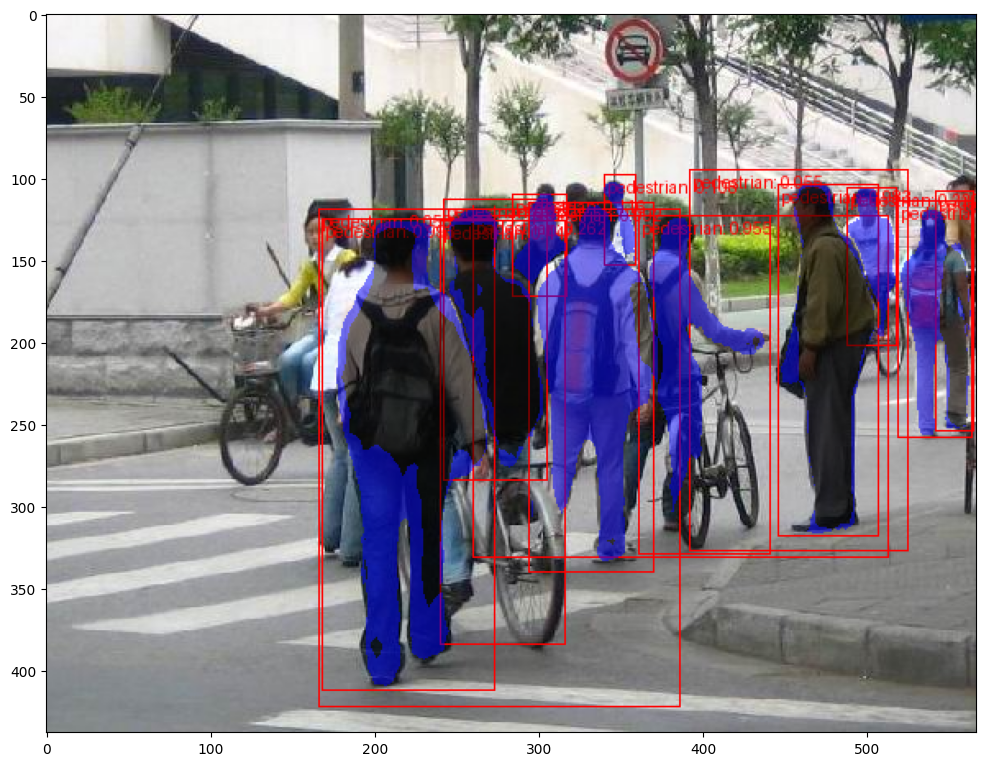

In [42]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

print(pred)
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))